# **Spotify Web API Task 4: Coverting a YouTube Music Playlist to a Spotify Playlist.** #
### **Overview**

This notebook will guide you through using the Spotify Developer Web API and the YouTube Data API to create a program that imports a YouTube Music playlist and generates a corresponding playlist on a user's Spotify profile. The program then populates this new playlist with tracks from YouTube.

This program assumes the user has already obtained an OAuth token and a refresh token, both of which should be saved in an `.env` file in the notebook's directory. Using these credentials, the notebook will refresh the OAuth token and update the `.env` file with the new token. Please review the prerequisite actions listed below before proceeding.
<br>

### **Prerequisites**

Before starting, ensure you have completed the following steps and saved the necessary credentials in your `.env` file:

- **OAuth Token**: Required for accessing the Spotify Web API. It expires after one hour.

- **Refresh Token**: Allows you to generate new OAuth tokens when the current one expires. We will use the refresh token to obtain a new access token in Task 2.
  
Additionally, you need to set up a Spotify Developer App and save the following details in your `.env` file:

- **Client ID**: A unique identifier for your Spotify application.

- **Client Secret**: A secret key used to authenticate requests to the Spotify Web API.

You should also store your Spotify profile details:

- **Spotify Username**: The username or email used to log into Spotify.

- **Spotify User ID**: Your unique Spotify ID, which can be found in your Spotify user profile on the web player.

Finally, ensure you have the YouTube playlist URL ready:

- **YouTube Playlist URL**: The URL of the YouTube playlist you wish to transfer to Spotify.

> **Note**: Never hardcode sensitive information (such as tokens, client IDs, client secrets, etc.) directly into your scripts. Doing so poses security risks. Instead, store them securely in an `.env` file and load them into the program as needed. The functions in this notebook will retrieve variables from the `.env` file when required.
<br>

### **Step-by-Step Guide**

1) **Import Libraries**: Begin by importing the required Python libraries.
  
2) **Function to Obtain a New OAuth Token**: This function generates a new OAuth token using the refresh token that was previously saved.
  
3) **Function to Retrieve YouTube Video Titles**: This function takes the YouTube playlist ID and returns a list of video titles.
  
4) **Function to Clean YouTube Titles**: This function cleans and formats the YouTube video titles, returning a list of tuples containing the artist's name and track title.
  
5) **Function to Create a Spotify Playlist**: This function creates a new playlist on the user’s Spotify profile and returns the Spotify Playlist ID.
  
6) **Function to Retrieve Spotify Track URIs**: This function uses the song title and artist to search for and return the corresponding Spotify URI.
  
7) **Function to Add Songs to Spotify Playlist**: This final function integrates all previous steps. It prompts the user for their details, creates a Spotify playlist, and populates it with tracks from the YouTube playlist. If successful, a completion message will be displayed.
<br>

### **Project Limitations**

A few caveats to be aware of:

- YouTube playlist titles must follow the format "Artist - Song" (the most common title format). The cleaning function accounts for some variations, but certain titles may still pose challenges.

- The program removes featured artists in video titles, but discrepancies like remixes or alternate versions in parentheses may not be handled perfectly.

- An OAuth token must be manually generated, and the details must be stored in the `.env` file.

- YouTube playlists must be public for the API to access them.
  
I plan to enhance this program in the future to improve robustness and handle edge cases more effectively.


In [1]:
# Import rerlevant libraries 

from urllib.parse import urlparse, parse_qs
from googleapiclient.discovery import build
from dotenv import load_dotenv, set_key
import os
import base64
import requests
import json 
import re

In [3]:
# Making a function to obtain a new Refresh Token. 
def get_refresh_token () -> str : 

    """
    This function creates a new Spotify OAuth Token for the user's account which grants 
    access to our app in the Spotify Developer API.

    Returns:
        str: The new access token, which is also updated in the .env file 
    
    Raises:
        ValueError: If credentials are missing from the .env file.
        Exception: If refreshiing the OAuth token fails.
    """

    # Getting Spotify API information 
    load_dotenv()
    client_id = os.getenv('CLIENT_ID')
    client_secret = os.getenv('CLIENT_SECRET')
    refresh_token = os.getenv('REFRESH_TOKEN')

    if not all([client_id, client_secret, refresh_token]):
        raise ValueError("Missing credentials in .env file, please check")

    # Exchange details for new OAuth Token 

    # URL of the Spotify API endpoint which issues OAuth tokens
    token_url = 'https://accounts.spotify.com/api/token'   
    # Encode client credentials (Base64 encoding), Spotify's token endpoint expects this in the 'Authorization' header
    client_credentials = f"{client_id}:{client_secret}"
    encoded_credentials = base64.b64encode(client_credentials.encode()).decode()

    # HTTP Headers are neccessary to authenicate and specify the request 
    # Content type specifies the format of the data being sent to the API
    headers = {
    'Authorization': f'Basic {encoded_credentials}',
    'Content-Type': 'application/x-www-form-urlencoded'
    }
    # Specifies the method we are using to obtain the OAuth token  
    data = {
    'grant_type': 'refresh_token',
    'refresh_token': refresh_token
    }

    # Make the POST request to get the new access token
    response = requests.post(token_url, headers=headers, data=data)

    # Checking if the request was successful and obtain the access and refresh tokens
    if response.status_code == 200:
        token_info = response.json()
        new_access_token = token_info['access_token']
    
        # Update the .env file with the new access token
        env_file = '.env'
        set_key(env_file, 'OAUTH_TOKEN', new_access_token)

    else : raise Exception (f"Error Refreshing OAuth Token : {response.text}")

    
    return new_access_token

In [4]:
# Making a function which tkaes in a YouTube Playlust URL and returns a list of the titles.
def get_youtube_titles() -> str : 
    
    """
    This function asks the user for the YouTube Playlist URL and uses the YouTube Data API to return a list of the video titles.
    
    Returns:
        list[str]: A list of video titles in the YouTube playlist.

    Raises:
        ValueError: If credentials are missing from the ENV file.
        Exception: If refreshiing the OAuth token fails.
    """
     
    youtube_playlist = input("Please paste in the full URL of the YouTube playlist you wish to import to Spotify")

    # Parse through YouTube URL to get Playlist ID 
    parsed_url = urlparse(youtube_playlist)
    query_params = parse_qs(parsed_url.query)
    youtube_playlist_list = query_params.get('list')
    youtube_playlist_id = youtube_playlist_list[0]

    
    if not youtube_playlist_id : 
        raise Exception ("Error Obtaining YouTube Playlist ID")
    
    load_dotenv()
    youtube_api_key = os.getenv('YOUTUBE_API_KEY')

    if not youtube_api_key:
        raise ValueError("YouTube API key is not set. Please set the 'YOUTUBE_API_KEY' environment variable.")

    # Build the YouTube service object
    youtube = build('youtube', 'v3', developerKey= youtube_api_key)

    video_titles = []
    next_page_token = None

    while True:
        # Fetch the YouTube playlist items
        request = youtube.playlistItems().list(
            part='snippet',
            playlistId=youtube_playlist_id,
            maxResults=50,  # Max results per API request
            pageToken=next_page_token
        )

        # Execute the request and parse the response
        response = request.execute()
    
        for item in response['items']:
            video_title = item['snippet']['title']
            video_titles.append(video_title)

        # Check if there's another page of results
        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break

    return video_titles



In [12]:
# Making function which cleans the YouTube video titles, and returns a list of tuples containing song name and artist
def clean_titles(song_list : list) -> list[tuple]:

    """
    This function takes a list of YouTube song video titles in the format 'artist - track' and cleans the track titles
    by removing any parenthetical content and references to 'featuring' or 'ft.'.

    Args:
        song_list (list): A list of song titles in the format 'artist - track'.

    Returns:
        list[tuple]: A list of tuples where each tuple contains the cleaned artist name and track title.

    Raises : 
        ValueError : When the video title doesn't follow the artist - title format 
    """


    song_info = []

    for song in song_list:
        try:
            # Split the string into artist and track by the first ' - ' separator
            artist, track = song.split(' - ', 1)

            # Remove any text within parentheses (including the parentheses)
            track_cleaned = re.sub(r'\s*\(.*?\)\s*', '', track)

            # Remove 'ft.', 'featuring', and variations, along with anything after it
            track_cleaned = re.sub(r'\s+(ft\.?|featuring)\s+.*', '', track_cleaned, flags=re.IGNORECASE)

            # Append the cleaned artist and track as a tuple
            song_info.append((artist.strip(), track_cleaned.strip()))
        except ValueError:
            # Handle cases where the song string doesn't follow the expected 'artist - track' format
            print(f"Error processing: {song}")
            song_info.append((song.strip(), ''))

    return song_info

In [7]:
# Making function which takes in the new OAUTH token and user Spotify ID then creates a Spotify playlist on the users account and returns the playlist ID
def create_playlist(new_access_token) :
        
        """
        This function creates a new Spotify playlist in the user's account using the Spotify Web API.

        Args : 
           new_access_token (str) : The new Spotify OAuth token created in the first function.

        Returns:
           str: The ID of the newly created Spotify playlist.
    
        Raises:
           ValueError: If the Spotify OAUTH token or user ID is missing.
           Exception: If the Spotify playlist creation or playlist ID retrieval fails.
        """


        # Fetch access user ID from environment variables
        load_dotenv()
        spotify_id = os.getenv('SPOTIFY_ID')

        # Check if user ID is available
        if not spotify_id:
           raise ValueError("User ID is missing. Please set the 'USER_ID' environment variable.")
        
        if not new_access_token:
           raise ValueError("OAUTH token is missing.")


        # Request body for creating the playlist
        request_body = json.dumps({
                "name": "Aaron's Imported YouTube Music",
                "description": "This playlist was created using Python, the Spotify Developer API, and the YouTube Data API to import songs from a YouTube playlist", 
                "public": True
                })
        # API endpoint for creating a playlist
        url = f"https://api.spotify.com/v1/users/{spotify_id}/playlists"

        # Send POST request to create the playlist
        response = requests.post(
            url,
            data = request_body,
            headers = {
                "Content-Type": "application/json",
                "Authorization": f"Bearer {new_access_token}"
            }
        )
        # Check if the response was successful (status code 201)
        if response.status_code == 201:
           response_json = response.json()
           playlist_id = response_json['id']

           if playlist_id:
               return playlist_id
           else: 
               raise Exception("Failed to retrieve playlist ID from the response.")
        else:
            raise Exception(f"Failed to create playlist. Status code: {response.status_code}, Response: {response.text}")

In [8]:
# Making function which uses the Spotify Developer API to search for a songs URI, given a song name and artist
def get_spotify_uri (new_access_token : str, song_name : str, artist : str) -> str : 

    """
    This function fetches the Spotify URI of a song given the song name and artist using the Spotify Web API.
    
    Args:
        new_access_token (str) : The new OAuth token created in the first function.
        song_name (str): The name of the song to search for.
        artist (str): The name of the artist.

    Returns:
        str: The Spotify URI of the song.
    
    Raises:
        ValueError: If the OAuth token is missing or if no song is found.
        Exception: For any issues with the API request.
    """

    if not new_access_token:
        raise ValueError("OAUTH token is missing.")

    # Validate input parameters
    if not song_name or not artist:
        raise ValueError("Both 'song_name' and 'artist' must be provided.")
    
    # URL encode the song name and artist for the query
    query = f'https://api.spotify.com/v1/search?query=track%3A{song_name}+artist%3A{artist}&type=track&offset=0&limit=20'

    # Make the API request
    response = requests.get(
        query,
        headers = {
                "Content-Type": "application/json",
                "Authorization": f"Bearer {new_access_token}"
        })
    
    # Check if the response is successful (status code 200)
    if response.status_code != 200:
        raise Exception(f"Spotify API request failed. Status code: {response.status_code}, Response: {response.text}")

    # Parse JSON response
    response_json = response.json()
    songs = response_json['tracks']['items']

    # Check if any songs are found
    if not songs:
        raise ValueError(f"No songs found for '{song_name}' by '{artist}'.")

    # Return the URI of the first song
    uri = songs[0]['uri']

    return uri

In [9]:
# Making the final function which combines all earlier functions to add the tracks from the 
# YouTube videos to the users Spotify playlist
def add_songs_to_playlist(new_access_token : str, playlist_id : str, cleaned_titles : list[tuple]) -> str:

    """
    This function adds a list of songs to a Spotify playlist by their cleaned titles.
    
    Args:
        new_access_token (str) : The new OAuth token created in the first function.
        playlist_id (str): The ID of the Spotify playlist where songs will be added.
        cleaned_titles (list[tuple]): A list of tuples containing artist names and song titles.

    Returns:
        str: A success message indicating that songs have been added.
    
    Raises:
        ValueError : If the OAUTH Token is missing. 
        Exception: If there is an issue with adding songs to the playlist.
    """

    if not new_access_token:
        raise ValueError("OAUTH token is missing.")


    spotify_uris = []
    # Fetch the Spotify URI for each song in cleaned_titles
    for title in cleaned_titles:
        track = title[1]
        artist = title[0]
        try:
            spotify_uri = get_spotify_uri(new_access_token, track, artist)
            if spotify_uri:
                spotify_uris.append(spotify_uri)
        except Exception as e:
            print(f"Failed to get URI for {track} by {artist}: {e}")

    # Ensure there are tracks to add
    if not spotify_uris:
        raise Exception("No valid tracks found to add to the playlist.")



 # Add tracks in batches of 100 (Spotify's API limit)
    batch_size = 100
    for i in range(0, len(spotify_uris), batch_size):
        request_data = json.dumps(spotify_uris[i:i + batch_size])
        query = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"

        response = requests.post(
            query,
            data=request_data,
            headers={
                "Content-Type": "application/json",
                "Authorization": f"Bearer {new_access_token}"
            }
        )

        # Check if the request was successful
        if response.status_code != 201:
            raise Exception(f"Error adding songs: {response.status_code} - {response.text}")

    print("Songs successfully added to the playlist!")


In [10]:
# Making the final function which combines all earlier functions to add the tracks from the 
# YouTube videos to the users Spotify playlist
def convert_youtube_playlist () : 

    """
    This function converts a YouTube playlist to a Spotify playlist by fetching the titles
    from a YouTube playlist, cleaning them, creating a new Spotify playlist, fetching Spotify
    URIs for the cleaned titles, and adding the songs to the newly created Spotify playlist.
    """

    # Step 1 : Get new OAUTH Token 
    token = get_refresh_token()

    # Step 2 : Fetch video titles from YouTube Playlist 
    video_titles = get_youtube_titles()

    # Step 3: Clean the titles (remove unwanted text, etc.)
    cleaned_titles = clean_titles(video_titles)

    # Step 4: Create a new Spotify playlist on users profile and get its ID
    playlist_id = create_playlist(token)

    # Step 6: Add the fetched Spotify URIs to the newly created Spotify playlist
    add_songs_to_playlist(token, playlist_id, cleaned_titles)










In [13]:
# Testing the final function
convert_youtube_playlist()

Songs successfully added to the playlist!


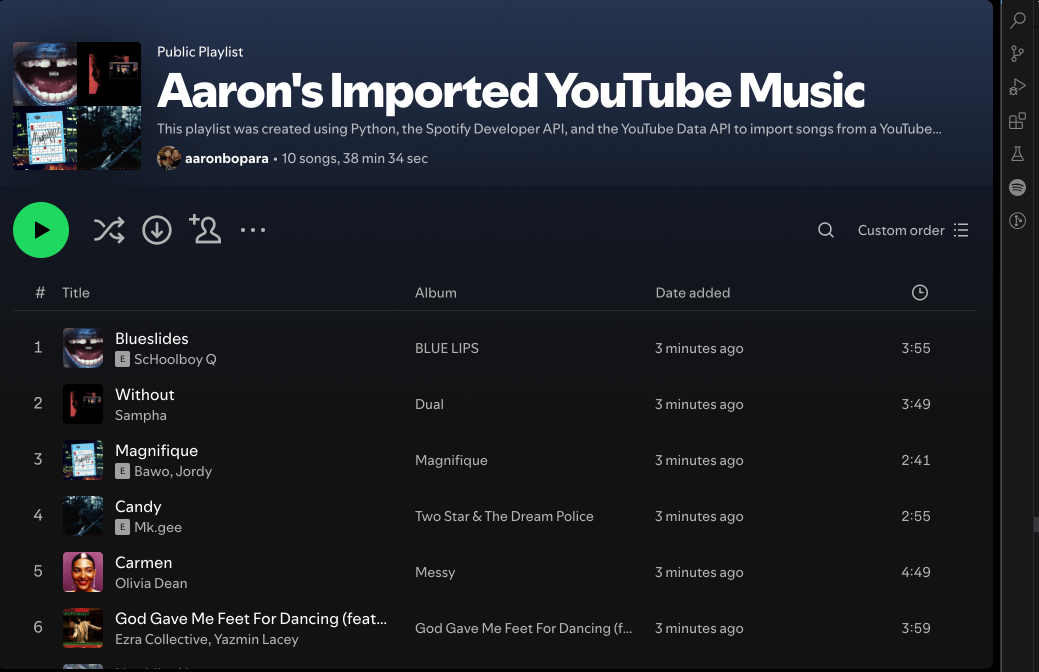

In [14]:
# Displaying the Spotify playlist inside my Spotify Desktopp App 
from IPython.display import Image 
Image('spotify_screenshot.png')

